In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 10.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import contractions

In [ ]:
df = pd.read_csv('/content/CLAN_data.csv')
print(df.head())

   PID                                  Social Media Post  \
0    1  President \n @realDonaldTrump\n : "Biden's pla...   
1    2  IMPORTANT ANNOUNCEMENT - CORONAVIRUS\nLast eve...   
2    3                         Heart is delighted to hear   
3    4  An allowed appeal is one where the initial ref...   
4    5  WARM WATER THERAPY\nDr. D. Mensah Asare says t...   

                                    Normalized Claim  
0  Biden’s energy plan would get rid of seniors’ ...  
1  If someone with the new coronavirus sneezes, i...  
2                         Heart is delighted to hear  
3  The vast majority of people coming across the ...  
4  A widely popular social media post claims that...  


In [ ]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=.3, random_state=42)

# Split the remaining data into validation and test sets
val_df, test_df = train_test_split(test_df, test_size=.5, random_state=42)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Train set size: 1967
Validation set size: 422
Test set size: 422


In [ ]:
abbreviation_df = pd.read_csv("/content/Abbreviations and Slang.csv")
abb_dict = dict(zip(abbreviation_df['Abbreviations'], abbreviation_df['Text']))

In [ ]:
def preprocess_text(text):
    if not isinstance(text, str):
        return text
    text = contractions.fix(text)
    expanded_text = text.lower()

    words = expanded_text.split()
    expanded_text = " ".join([abb_dict.get(word, word) for word in words])
    # Remove links
    expanded_text = re.sub(r'http\S+|www\S+', '', expanded_text)
    # Remove special characters (except for alphanumeric and spaces)
    expanded_text = re.sub(r'[^a-zA-Z0-9\s]', '', expanded_text)
    # Remove extra whitespace
    expanded_text = re.sub(r'\s+', ' ', expanded_text).strip()

    return expanded_text

In [ ]:
print(preprocess_text("Gov. VP lnk.com #NO"))

In [ ]:
for i in train_df.columns:
  train_df[i] = train_df[i].apply(preprocess_text)
train_df.head()

In [ ]:
for i in test_df.columns:
  test_df[i] = test_df[i].apply(preprocess_text)
test_df.head()

In [ ]:
for i in val_df.columns:
  val_df[i] = val_df[i].apply(preprocess_text)
val_df.head()

In [ ]:
train_df.to_csv('/content/train_df.csv', index=False)
test_df.to_csv('/content/test_df.csv', index=False)
val_df.to_csv('/content/val_df.csv', index=False)

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

In [14]:
import torch
torch.cuda.empty_cache()
# from transformers import BartForConditionalGeneration, AutoTokenizer, Trainer, TrainingArguments
from transformers import T5ForConditionalGeneration, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer
from datasets import load_dataset

In [15]:
def clean_data(examples):
    # Ensure text fields are strings and handle None/NaN values
    examples["Social Media Post"] = [str(post) if post is not None else "" for post in examples["Social Media Post"]]
    examples["Normalized Claim"] = [str(claim) if claim is not None else "" for claim in examples["Normalized Claim"]]
    return examples

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
tokenizer = AutoTokenizer.from_pretrained("t5-base")

dataset = load_dataset("csv", data_files={
    "train": "/content/train_df.csv",
    "validation": "/content/val_df.csv",
    "test" : "/content/test_df.csv"
})

def tokenize_function(examples, model_name):
  if model_name == "Bart":
    return tokenizer(examples["Social Media Post"], padding="max_length", truncation=True, max_length=512)
  elif model_name == "T5":
    inputs = ["normalize claim: " + post for post in examples["Social Media Post"]]
    return tokenizer(inputs, padding="max_length", truncation=True, max_length=512)

def format_labels(examples):
    examples["labels"] = tokenizer(examples["Normalized Claim"], padding="max_length", truncation=True, max_length=512)["input_ids"]
    return examples


Using device: cuda


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [17]:
model_name = "T5"

tokenized_train = (dataset["train"]
    .map(clean_data, batched=True)
    .map(lambda x: tokenize_function(x, model_name), batched=True)
    .map(format_labels, batched=True)
)

tokenized_val = (dataset["validation"]
    .map(clean_data, batched=True)
    .map(lambda x: tokenize_function(x, model_name), batched=True)
    .map(format_labels, batched=True)
)

tokenized_test = (dataset["test"]
    .map(clean_data, batched=True)
    .map(lambda x: tokenize_function(x, model_name), batched=True)
    .map(format_labels, batched=True)
)

Map:   0%|          | 0/1967 [00:00<?, ? examples/s]

Map:   0%|          | 0/1967 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

In [18]:
# bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)
t5_model = T5ForConditionalGeneration.from_pretrained("t5-base").to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# !unzip /content/t5_Finetuned2.zip -d /content/

Archive:  /content/t5_Finetuned2.zip
   creating: /content/t5_Finetuned2/
  inflating: /content/t5_Finetuned2/config.json  
  inflating: /content/t5_Finetuned2/generation_config.json  
  inflating: /content/t5_Finetuned2/model.safetensors  
  inflating: /content/t5_Finetuned2/special_tokens_map.json  
  inflating: /content/t5_Finetuned2/spiece.model  
  inflating: /content/t5_Finetuned2/tokenizer.json  
  inflating: /content/t5_Finetuned2/tokenizer_config.json  


In [ ]:
# |!wandb login 419897dfeb921851ebb05f106d652ef194bd425b

wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [22]:
training_args = TrainingArguments(
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=4,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir='./logs_bart',
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [8]:
trainer_bart = Trainer(
    model=bart_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
)

In [9]:
trainer_bart.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vimal22571 (vimal22571-indraprastha-institute-of-information-technol) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,0.127771
2,No log,0.112446
3,1.416800,0.109992
4,1.416800,0.108252
5,0.096600,0.107744
6,0.096600,0.107551
7,0.084000,0.107509


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=1722, training_loss=0.4741995641994144, metrics={'train_runtime': 2385.213, 'train_samples_per_second': 5.773, 'train_steps_per_second': 0.722, 'total_flos': 4197730646753280.0, 'train_loss': 0.4741995641994144, 'epoch': 7.0})

In [23]:
trainer_t5 = Trainer(
    model=t5_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
)

In [24]:
trainer_t5.train()

Epoch,Training Loss,Validation Loss
1,No log,0.110353
2,0.245100,0.106189
3,0.104400,0.105025
4,0.089600,0.105404


TrainOutput(global_step=1968, training_loss=0.13175642393468842, metrics={'train_runtime': 2501.038, 'train_samples_per_second': 3.146, 'train_steps_per_second': 0.787, 'total_flos': 4791280682926080.0, 'train_loss': 0.13175642393468842, 'epoch': 4.0})

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
logs = trainer_bart.state.log_history

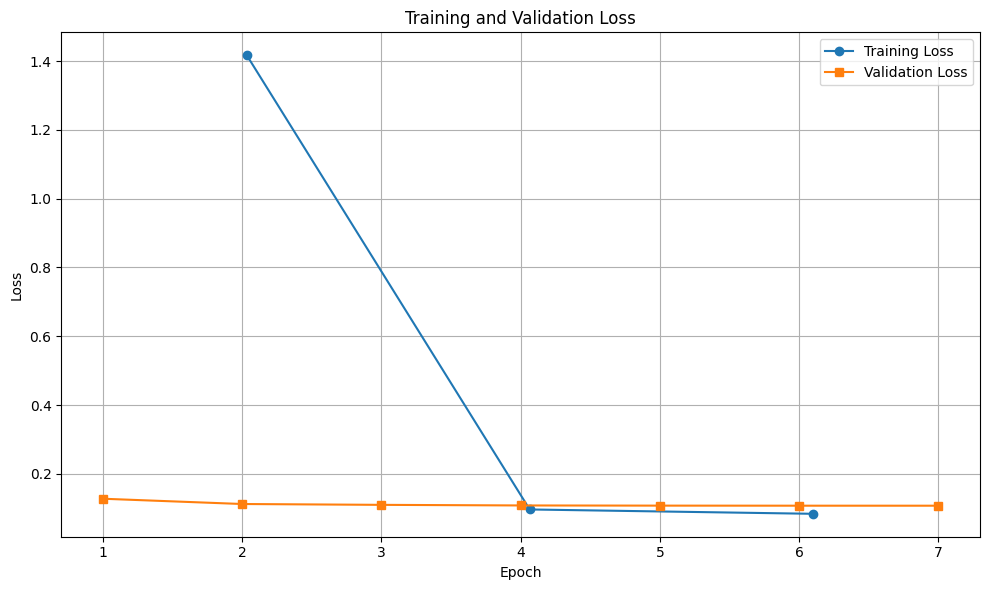

In [13]:
def plot_loss(log_history):
    train_epochs = []
    train_losses = []
    val_epochs = []
    val_losses = []
    for entry in log_history:
        if 'loss' in entry and 'epoch' in entry:
            train_epochs.append(entry['epoch'])
            train_losses.append(entry['loss'])
        elif 'eval_loss' in entry and 'epoch' in entry:
            val_epochs.append(entry['epoch'])
            val_losses.append(entry['eval_loss'])

    plt.figure(figsize=(10, 6))

    plt.plot(train_epochs, train_losses, label='Training Loss', marker='o')

    if val_epochs:
        plt.plot(val_epochs, val_losses, label='Validation Loss', marker='s')

    all_epochs = train_epochs + val_epochs
    max_epoch = int(max(all_epochs)) + 1
    plt.xticks(range(1, max_epoch))

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_loss(logs)

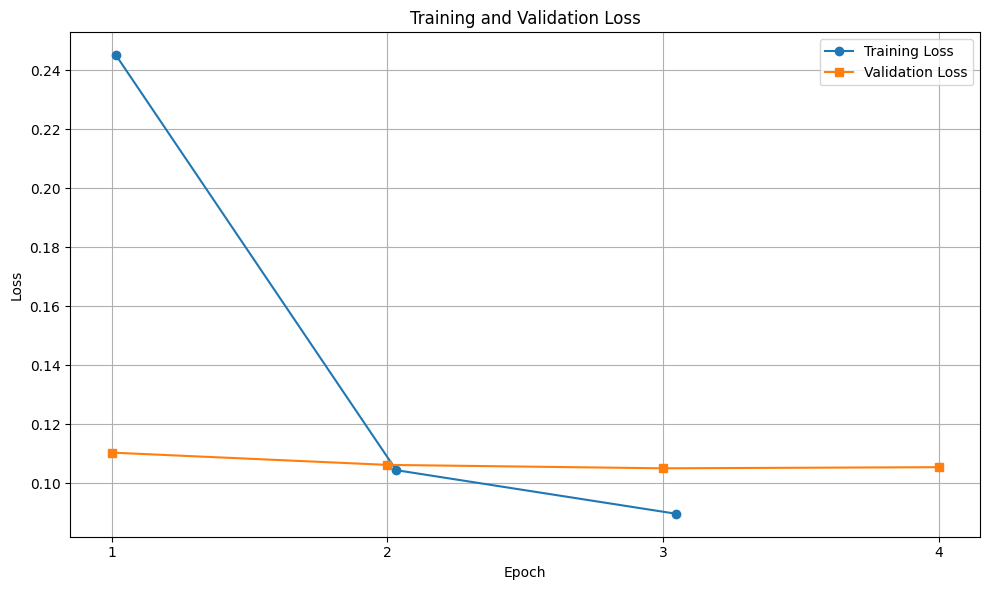

In [26]:
logst5 = trainer_t5.state.log_history
plot_loss(logst5)

In [ ]:
# bart_save_path = "/content/t5_finetuned"
# t5_model.save_pretrained(bart_save_path)

In [ ]:
# tokenizer.save_pretrained(bart_save_path)

In [ ]:
!pip install rouge_score
!pip install nltk
!pip install bert_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=0400d27251c1ad3c7612eed0b289fcb8b04dc396e139d889a8ef483f4b66e3b1
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import numpy as np
from transformers import BartForConditionalGeneration, T5ForConditionalGeneration, AutoTokenizer
from datasets import Dataset
import pandas as pd
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from bert_score import score as bert_score
from tqdm import tqdm
import random

In [ ]:
bart_save_path = "bart2_finetuned"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the fine-tuned model and tokenizer
model = BartForConditionalGeneration.from_pretrained(bart_save_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(bart_save_path)

def generate_prediction(text):
    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(**inputs, max_length=512, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def evaluate_model(val_dataset):
    # Convert dataset to list of dicts if it's a Dataset object
    if isinstance(val_dataset, Dataset):
        val_data = val_dataset
    else:
        val_data = Dataset.from_pandas(val_df)

    predictions = []
    references = []

    # Generate predictions
    for example in tqdm(val_data, desc="Generating predictions"):
        pred = generate_prediction(example["Social Media Post"])
        predictions.append(pred)
        references.append(example["Normalized Claim"])

    # Calculate ROUGE-L
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_l_f1_scores = []
    rouge_l_recall_scores = []
    rouge_l_precision_scores = []

    for ref, pred in zip(references, predictions):
        scores = rouge_scorer_obj.score(ref, pred)['rougeL']
        rouge_l_f1_scores.append(scores.fmeasure)
        rouge_l_recall_scores.append(scores.recall)
        rouge_l_precision_scores.append(scores.precision)

    avg_rouge_l_f1 = np.mean(rouge_l_f1_scores)
    avg_rouge_l_recall = np.mean(rouge_l_recall_scores)
    avg_rouge_l_precision = np.mean(rouge_l_precision_scores)

    # Calculate BLEU-4
    bleu_4_scores = []
    for ref, pred in zip(references, predictions):
        ref_tokens = ref.split()
        pred_tokens = pred.split()
        # BLEU-4 uses weights for 1-4 grams
        bleu_score = sentence_bleu([ref_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))
        bleu_4_scores.append(bleu_score)
    avg_bleu_4 = np.mean(bleu_4_scores)

    # Calculate BERTScore
    P, R, F1 = bert_score(predictions, references, lang="en", verbose=True)
    avg_bert_f1 = F1.mean().item()

    # Print results
    print("\nEvaluation Results:")
    print(f"Average ROUGE-L F1 Score: {avg_rouge_l_f1:.4f}")
    print(f"Average ROUGE-L Recall: {avg_rouge_l_recall:.4f}")
    print(f"Average ROUGE-L Precision: {avg_rouge_l_precision:.4f}")
    print(f"Average BLEU-4 Score: {avg_bleu_4:.4f}")
    print(f"Average BERTScore F1: {avg_bert_f1:.4f}")

    return {
        "rouge_l_f1": avg_rouge_l_f1,
        "rouge_l_recall": avg_rouge_l_recall,
        "rouge_l_precis ion": avg_rouge_l_precision,
        "bleu_4": avg_bleu_4,
        "bertscore_f1": avg_bert_f1
    }


Using device: cuda


In [ ]:
results = evaluate_model(tokenized_test)

Generating predictions: 100%|██████████| 422/422 [01:44<00:00,  4.02it/s]
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Cons

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 4.79 seconds, 88.03 sentences/sec

Evaluation Results:
Average ROUGE-L F1 Score: 0.3835
Average ROUGE-L Recall: 0.4052
Average ROUGE-L Precision: 0.4186
Average BLEU-4 Score: 0.2114
Average BERTScore F1: 0.8792


In [ ]:
t5_save_path = "t5_Finetuned2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the fine-tuned model and tokenizer
model = T5ForConditionalGeneration.from_pretrained(t5_save_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(t5_save_path)

def generate_prediction(text):
    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(**inputs, max_length=512, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def evaluate_model(val_dataset):
    # Convert dataset to list of dicts if it's a Dataset object
    if isinstance(val_dataset, Dataset):
        val_data = val_dataset
    else:
        val_data = Dataset.from_pandas(val_df)

    predictions = []
    references = []

    # Generate predictions
    for example in tqdm(val_data, desc="Generating predictions"):
        pred = generate_prediction(example["Social Media Post"])
        predictions.append(pred)
        references.append(example["Normalized Claim"])

    # Calculate ROUGE-L
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_l_f1_scores = []
    rouge_l_recall_scores = []
    rouge_l_precision_scores = []

    for ref, pred in zip(references, predictions):
        scores = rouge_scorer_obj.score(ref, pred)['rougeL']
        rouge_l_f1_scores.append(scores.fmeasure)
        rouge_l_recall_scores.append(scores.recall)
        rouge_l_precision_scores.append(scores.precision)

    avg_rouge_l_f1 = np.mean(rouge_l_f1_scores)
    avg_rouge_l_recall = np.mean(rouge_l_recall_scores)
    avg_rouge_l_precision = np.mean(rouge_l_precision_scores)

    # Calculate BLEU-4
    bleu_4_scores = []
    for ref, pred in zip(references, predictions):
        ref_tokens = ref.split()
        pred_tokens = pred.split()
        # BLEU-4 uses weights for 1-4 grams
        bleu_score = sentence_bleu([ref_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))
        bleu_4_scores.append(bleu_score)
    avg_bleu_4 = np.mean(bleu_4_scores)

    # Calculate BERTScore
    P, R, F1 = bert_score(predictions, references, lang="en", verbose=True)
    avg_bert_f1 = F1.mean().item()

    # Print results
    print("\nEvaluation Results:")
    print(f"Average ROUGE-L F1 Score: {avg_rouge_l_f1:.4f}")
    print(f"Average ROUGE-L Recall: {avg_rouge_l_recall:.4f}")
    print(f"Average ROUGE-L Precision: {avg_rouge_l_precision:.4f}")
    print(f"Average BLEU-4 Score: {avg_bleu_4:.4f}")
    print(f"Average BERTScore F1: {avg_bert_f1:.4f}")

    return {
        "rouge_l_f1": avg_rouge_l_f1,
        "rouge_l_recall": avg_rouge_l_recall,
        "rouge_l_precision": avg_rouge_l_precision,
        "bleu_4": avg_bleu_4,
        "bertscore_f1": avg_bert_f1
    }


Using device: cuda


In [ ]:
results = evaluate_model(tokenized_test)

Generating predictions: 100%|██████████| 422/422 [04:50<00:00,  1.45it/s]
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Cons

calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 4.74 seconds, 89.12 sentences/sec

Evaluation Results:
Average ROUGE-L F1 Score: 0.3325
Average ROUGE-L Recall: 0.3595
Average ROUGE-L Precision: 0.3574
Average BLEU-4 Score: 0.1613
Average BERTScore F1: 0.8696


----

# Testing Pipeline

In [2]:
import numpy as np
import json
import pandas as pd
import re
import contractions

import torch
torch.cuda.empty_cache()
from transformers import BartForConditionalGeneration, AutoTokenizer
from transformers import AutoTokenizer
from datasets import load_dataset

from datasets import Dataset
import pandas as pd
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from bert_score import score as bert_score
from tqdm import tqdm

In [3]:
df = pd.read_csv('test.csv')
print(df.head())
abbreviation_df = pd.read_csv("Updated_Abbreviations_and_Slang.csv")
abb_dict = dict(zip(abbreviation_df['Abbreviations'], abbreviation_df['Text']))

   PID                                  Social Media Post  \
0    1   40 students admitted after vaccination in Kanpur   
1    2  Cold Comfort to the 400 Families whose loved o...   
2    3  Trucker's (sic) that refuse the Jab have refus...   
3    4               Indian Air Force, Salute Indian Army   
4    5  How many more people have to die before we rei...   

                                    Normalized Claim  
0   40 students admitted after vaccination in Kanpur  
1  Health Minister Greg Hunt admitted no one in t...  
2  The claim: Resistance to COVID-19 vaccine mand...  
3               Indian Air Force, Salute Indian Army  
4  "After (the assault weapon ban) passed in 1994...  


In [4]:
def preprocess_text(text):
    if not isinstance(text, str):
        return text
    text = contractions.fix(text)
    expanded_text = text.lower()

    words = expanded_text.split()
    expanded_text = " ".join([abb_dict.get(word, word) for word in words])

    expanded_text = re.sub(r'http\S+|www\S+', '', expanded_text)

    expanded_text = re.sub(r'[^a-zA-Z0-9\s]', '', expanded_text)

    expanded_text = re.sub(r'\s+', ' ', expanded_text).strip()

    return expanded_text

def clean_data(examples):
    examples["Social Media Post"] = [str(post) if post is not None else "" for post in examples["Social Media Post"]]
    examples["Normalized Claim"] = [str(claim) if claim is not None else "" for claim in examples["Normalized Claim"]]
    return examples

In [5]:
for i in df.columns:
  df[i] = df[i].apply(preprocess_text)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

dataset = {"test": Dataset.from_pandas(df)}

def tokenize_function(examples, model_name):
  if model_name == "Bart":
    return tokenizer(examples["Social Media Post"], padding="max_length", truncation=True, max_length=512)
  elif model_name == "T5":
    inputs = ["normalize claim: " + post for post in examples["Social Media Post"]]
    return tokenizer(inputs, padding="max_length", truncation=True, max_length=512)

def format_labels(examples):
    examples["labels"] = tokenizer(examples["Normalized Claim"], padding="max_length", truncation=True, max_length=512)["input_ids"]
    return examples

Using device: cuda


In [6]:
model_name = "Bart"

tokenized_test = (dataset["test"]
    .map(clean_data, batched=True)
    .map(lambda x: tokenize_function(x, model_name), batched=True)
    .map(format_labels, batched=True)
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [7]:
bart_save_path = "Final_Model"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = BartForConditionalGeneration.from_pretrained(bart_save_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(bart_save_path)

def generate_prediction(text):
    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(**inputs, max_length=512, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def evaluate_model(val_dataset):
    if isinstance(val_dataset, Dataset):
        val_data = val_dataset
    else:
        val_data = Dataset.from_pandas(val_df)

    predictions = []
    references = []

    for example in tqdm(val_data, desc="Generating predictions"):
        pred = generate_prediction(example["Social Media Post"])
        predictions.append(pred)
        references.append(example["Normalized Claim"])

    rouge_scorer_obj = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_l_f1_scores = []
    rouge_l_recall_scores = []
    rouge_l_precision_scores = []

    for ref, pred in zip(references, predictions):
        scores = rouge_scorer_obj.score(ref, pred)['rougeL']
        rouge_l_f1_scores.append(scores.fmeasure)
        rouge_l_recall_scores.append(scores.recall)
        rouge_l_precision_scores.append(scores.precision)

    avg_rouge_l_f1 = np.mean(rouge_l_f1_scores)
    avg_rouge_l_recall = np.mean(rouge_l_recall_scores)
    avg_rouge_l_precision = np.mean(rouge_l_precision_scores)

    bleu_4_scores = []
    for ref, pred in zip(references, predictions):
        ref_tokens = ref.split()
        pred_tokens = pred.split()
        bleu_score = sentence_bleu([ref_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))
        bleu_4_scores.append(bleu_score)
    avg_bleu_4 = np.mean(bleu_4_scores)


    P, R, F1 = bert_score(predictions, references, lang="en", verbose=True)
    avg_bert_f1 = F1.mean().item()

    print("\nEvaluation Results:")
    print(f"Average ROUGE-L F1 Score: {avg_rouge_l_f1:.4f}")
    print(f"Average ROUGE-L Recall: {avg_rouge_l_recall:.4f}")
    print(f"Average ROUGE-L Precision: {avg_rouge_l_precision:.4f}")
    print(f"Average BLEU-4 Score: {avg_bleu_4:.4f}")
    print(f"Average BERTScore F1: {avg_bert_f1:.4f}")

    return {
        "rouge_l_f1": avg_rouge_l_f1,
        "rouge_l_recall": avg_rouge_l_recall,
        "rouge_l_precis ion": avg_rouge_l_precision,
        "bleu_4": avg_bleu_4,
        "bertscore_f1": avg_bert_f1
    }


Using device: cuda


In [8]:
results = evaluate_model(tokenized_test)

Generating predictions: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]
c:\Users\Akshat\anaconda3\envs\cuda_env\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Akshat\anaconda3\envs\cuda_env\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Akshat\anaconda3\envs\cuda_env\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how

calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.88 seconds, 113.60 sentences/sec

Evaluation Results:
Average ROUGE-L F1 Score: 0.2084
Average ROUGE-L Recall: 0.2065
Average ROUGE-L Precision: 0.2348
Average BLEU-4 Score: 0.0620
Average BERTScore F1: 0.8494
